# Install libraries

In [ ]:
%pip install scikit-learn
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install lightgbm

# Load the dataset

In [28]:
import pandas as pd

# Load the dataset
heart_failure_df = pd.read_csv('data/heart.csv')

feature_names = heart_failure_df.columns[:-1]
target_col_name = 'HeartDisease'
cat_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'ST_Segment']

assert len(feature_names) == len(cat_features) + len(num_features) # sanity check

heart_failure_df.head() # display the first few rows of the dataframe

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Simple processing and run

## Encoding

In [29]:
from sklearn.preprocessing import LabelEncoder # Encode categorical features

label_encoder = LabelEncoder()

X = heart_failure_df.drop(target_col_name, axis=1)
y = heart_failure_df[target_col_name]

for col in cat_features:
    X[col] = label_encoder.fit_transform(X[col])

X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.0,2
1,49,0,2,160,180,0,1,156,0,1.0,1
2,37,1,1,130,283,0,2,98,0,0.0,2
3,48,0,0,138,214,0,1,108,1,1.5,1
4,54,1,2,150,195,0,1,122,0,0.0,2


In [31]:
from sklearn.model_selection import train_test_split # Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Helper functions

In [48]:
from matplotlib import pyplot as plt
import numpy as np

# Plot confusion matrix with annotations
def plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        pass
        # print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Random forest

Random Forest training accuracy: 1.0


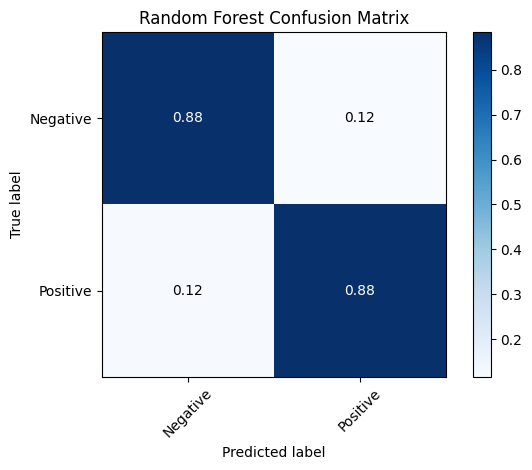

Feature ranking:
1. feature ST_Slope (0.235522)
2. feature Oldpeak (0.122366)
3. feature Cholesterol (0.104775)
4. feature ChestPainType (0.102754)
5. feature MaxHR (0.102066)
6. feature ExerciseAngina (0.098223)
7. feature Age (0.086603)
8. feature RestingBP (0.065854)
9. feature Sex (0.035495)
10. feature RestingECG (0.025843)
11. feature FastingBS (0.020498)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the classifier
rf_train_acc = rf_clf.score(X_train, y_train)
# Confusion matrix
rf_test_conf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test), normalize='true')
print(f"Random Forest training accuracy: {rf_train_acc}")
plt.figure()
plot_confusion_matrix(rf_test_conf_matrix, normalize=True, title='Random Forest Confusion Matrix')
plt.show()

# Feature importances
rf_feature_importances = rf_clf.feature_importances_
indices = np.argsort(rf_feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], rf_feature_importances[indices[f]]))

## LightGBM

LightGBM training accuracy: 1.0


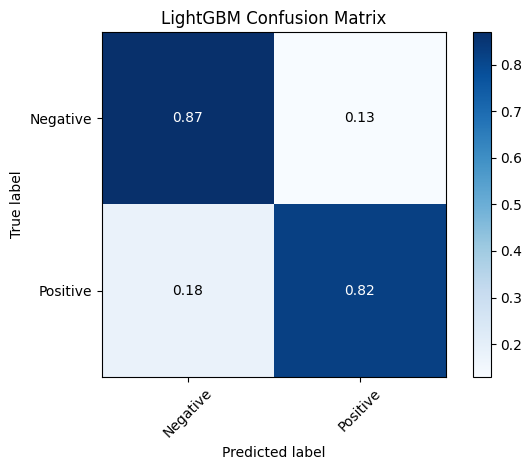

Feature ranking:
1. Feature 10 (ST_Slope): 1773.656075
2. Feature 9 (Oldpeak): 607.358000
3. Feature 4 (Cholesterol): 583.518156
4. Feature 7 (MaxHR): 547.963097
5. Feature 0 (Age): 421.864110
6. Feature 2 (ChestPainType): 416.383939
7. Feature 3 (RestingBP): 323.010672
8. Feature 8 (ExerciseAngina): 232.862513
9. Feature 1 (Sex): 210.933834
10. Feature 5 (FastingBS): 91.883349
11. Feature 6 (RestingECG): 87.121152


In [50]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

train_data = lgb.Dataset(X_train, label=y_train)

# Set LightGBM parameters for binary classification
params = {
    'objective': 'binary',  # Set the objective function to binary
    'metric': 'binary_logloss',  # Use binary_logloss as the evaluation metric
    "verbosity": -1
}

# Train the LightGBM model
num_round = 200
lgb_model = lgb.train(params, train_data, num_round)

# Predict the test set
y_pred = lgb_model.predict(X_test)
# Convert the predicted probabilities to binary
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate the accuracy of training
train_acc = accuracy_score(y_train, np.where(lgb_model.predict(X_train) > 0.5, 1, 0))
print(f"LightGBM training accuracy: {train_acc}")
# Calculate the confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_pred_binary, normalize='true')
plt.figure()
plot_confusion_matrix(test_conf_matrix, normalize=True, title='LightGBM Confusion Matrix')
plt.show()

# Get feature importance
lightgbm_feature_importances = lgb_model.feature_importance(importance_type='gain')
sorted_idx = np.argsort(lightgbm_feature_importances)[::-1]

# Print the feature importance ranking
print("Feature ranking:")
for i, idx in enumerate(sorted_idx):
    print("%d. Feature %d (%s): %f" % (i + 1, idx, feature_names[idx], lightgbm_feature_importances[idx]))

##### False Negative is still very high, considered for a medical classication problem, this is where we want to focus on improving.
##### Both _RandomForst_ and _LightGBM_ agree on the top 3 most important features, by order: _ST\_Slope_, _Oldpeak_, _Cholesterol_.

## Checking if imbalance in target

In [53]:
print(y.value_counts())

HeartDisease
1    508
0    410
Name: count, dtype: int64


##### Around 25% higher for Positive

Random Forest training accuracy (balanced): 1.0


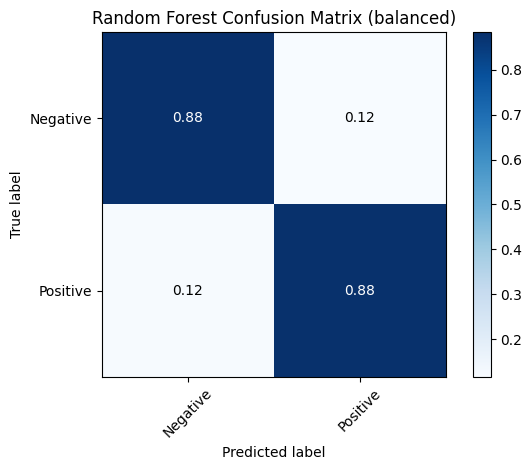

In [57]:
# Try different class_weight settings
rf_clf_balanced = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

rf_clf_balanced.fit(X_train, y_train)

# Evaluate the classifier
rf_train_acc_balanced = rf_clf_balanced.score(X_train, y_train)
# Confusion matrix
rf_test_conf_matrix_balanced = confusion_matrix(y_test, rf_clf_balanced.predict(X_test), normalize='true')
print(f"Random Forest training accuracy (balanced): {rf_train_acc_balanced}")
plot_confusion_matrix(rf_test_conf_matrix_balanced, normalize=True, title='Random Forest Confusion Matrix (balanced)')
plt.show()

Random Forest training accuracy (extreme): 1.0


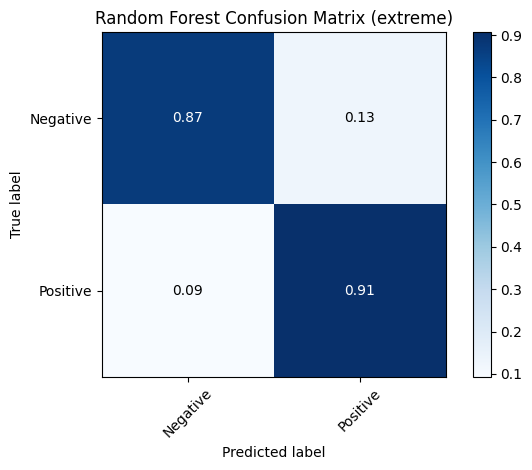

In [72]:
# A more extreme class weight setting
# Increasing the weight of the negative class to tell the model to focus more on the cases it thinks are negative
rf_clf_extreme = RandomForestClassifier(n_estimators=200, class_weight={0: 10, 1: 1}, random_state=42)

rf_clf_extreme.fit(X_train, y_train)

# Evaluate the classifier
rf_train_acc_extreme = rf_clf_extreme.score(X_train, y_train)
# Confusion matrix
rf_test_conf_matrix_extreme = confusion_matrix(y_test, rf_clf_extreme.predict(X_test), normalize='true')
print(f"Random Forest training accuracy (extreme): {rf_train_acc_extreme}")
plot_confusion_matrix(rf_test_conf_matrix_extreme, normalize=True, title='Random Forest Confusion Matrix (extreme)')
plt.show()

##### It does help a bit with the False Negative rate!

# More features engineering